In [1]:
import numpy as np
import argopy
from argopy import DataFetcher
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import gsw
from datetime import datetime
from cartopy.geodesic import Geodesic
from scipy import linalg
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, WhiteKernel, ConstantKernel as C
from sklearn.preprocessing import StandardScaler
from sklearn.metrics.pairwise import haversine_distances
from matplotlib.patches import Circle

import ArgoHeatContentDataCollater as ahdc
import ArgoGPR as ag

In [2]:
# 1. LOAD DATA
# Adjust path to your folder
df_argo = ahdc.load_argo_data_advanced(
    nc_dir='/home/avik2007/ArgoEBUSAnalysis/ArgoData/', 
    start_date='2018-01-01', 
    end_date='2019-01-01', # Grab a few months to test
    lat_bounds=[30, 40], 
    lon_bounds=[-126, -119]
)


🌊 INITIATING ARGO FETCH (Source: Erddap)
   Target: 2018-01-01 to 2019-01-01
   Region: Lat [30, 40] | Lon [-126, -119]
   Depth:  0m to 200m
   Save Path: /home/avik2007/ArgoEBUSAnalysis/ArgoData/argo_2018-01-01_to_2019-01-01_lat30_40_lon-126_-119_z0_200.pkl
   ✅ Data received from server.
   🔄 Processing profiles...
✅ COMPLETE: Loaded 12296 valid observations.
   💾 DataFrame saved to: /home/avik2007/ArgoEBUSAnalysis/ArgoData/argo_2018-01-01_to_2019-01-01_lat30_40_lon-126_-119_z0_200.pkl


In [4]:
jan_index = 1
feb_index = 2
jan_mask = [(df_argo['date'][i].month == jan_index) for i in range(0, len(df_argo))]
df_argo_january = df_argo[jan_mask]
feb_mask = [(df_argo['date'][i].month == feb_index) for i in range(0, len(df_argo))]
df_argo_february = df_argo[feb_mask]

In [5]:
df_argo_january_shallow = df_argo_january[df_argo_january['depth'] < 10]
df_argo_february_shallow = df_argo_february[df_argo_february['depth'] < 10]
df_argo_shallow = df_argo[df_argo['depth'] < 10]

In [5]:
df_argo_january_shallow

,lat,lon,temp,depth,time_days,float_id,date
0,31.20900,-120.53100,16.712,5.40,1.848449,5904022,2018-01-02 20:21:46
1,31.20900,-120.53100,16.704,9.10,1.848449,5904022,2018-01-02 20:21:46
21,33.23187,-125.44668,16.222,1.12,4.350382,4901640,2018-01-05 08:24:33
22,33.23187,-125.44668,16.223,2.04,4.350382,4901640,2018-01-05 08:24:33
23,33.23187,-125.44668,16.223,3.00,4.350382,4901640,2018-01-05 08:24:33
...,...,...,...,...,...,...,...
1016,35.84141,-124.23767,13.501,6.04,30.043206,5904378,2018-01-31 01:02:13
1017,35.84141,-124.23767,13.503,7.08,30.043206,5904378,2018-01-31 01:02:13
1018,35.84141,-124.23767,13.501,8.12,30.043206,5904378,2018-01-31 01:02:13
1019,35.84141,-124.23767,13.503,9.00,30.043206,5904378,2018-01-31 01:02:13


# have gemini add a warning about the convergence. if the optimal value is near the limit, then it will likely be a divergent length scale. 

#MOVING WINDOW WITH VARIABLE PARAMETERS REQUIRES PARALLELIZATION! 

In [ ]:
# 2. RUN LOOO in 3D (time, lat, lon) (Baseline Check)
# This validates if the model works mathematically (CHECKING FOR TIME)
# IN PRACTICE - YOU HAVE TO CREATE A LOOP WHERE YOU CHECK IF THE STD IS TOO LARGE OR TOO SMALL, AND THEN ADJUST. The AUTOTUNE IS PRETTY GOOD, BUT THAT MAY NOT ALWAYS BE TRUE
z_looo = ag.generalized_cross_validation(
    df_argo_january_shallow, 
    feature_cols=['lat', 'lon', 'time_days'], # 2D Spatial Only for now
    method='KFold', k_fold_data_percent=2, tune_subsample_frac=0.1
)



🚀 STARTING GLOBAL VALIDATION: KFold
   🤖 AutoTuning: Running 5 iterations on 97 points (10.0%) to estimate correlation lengths/times...
      (Constraint: Length Scale capped at 6.81 standard deviations)


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 6.8078335431467165. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 6.8078335431467165. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 6.8078335431467165. Increasing the bound and calling

      ✅ LEARNED HYPERPARAMETERS (Avg of 5 runs):
         Noise (Uncertainty): ±0.025 °C
         Correlation Lengths:
           - lat: 0.339°  (~38 km)
           - lon: 7.374°  (~667 km at 35.5N)
           - time_days: 31.3 days
   ⚡ Strategy: 50-Fold CV (Testing 2% per fold)
   Processed fold 46...
✅ RESULTS (KFold):
   RMSE:                0.026 °C
   Rel. Error (RMSRE):  0.0020 (dimensionless)
   Mean Z:              -0.002
   Std Z:               0.989 (Ideal: 1.0)


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 6.8078335431467165. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/model_selection/_split.py:87: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


In [15]:
# 2. RUN LOOO in 3D (time, lat, lon) (Baseline Check)
# This validates if the model works mathematically
# IN PRACTICE - YOU HAVE TO CREATE A LOOP WHERE YOU CHECK IF THE STD IS TOO LARGE OR TOO SMALL, AND THEN ADJUST. The AUTOTUNE IS PRETTY GOOD, BUT THAT MAY NOT ALWAYS BE TRUE
z_looo = ag.generalized_cross_validation(
    df_argo_february_shallow, 
    feature_cols=['lat', 'lon', 'time_days'], # 2D Spatial Only for now
    method='KFold', k_fold_data_percent=2, tune_subsample_frac=0.1
)


🚀 STARTING GLOBAL VALIDATION: KFold
   🤖 AutoTuning: Running 5 iterations on 89 points (10.0%) to estimate correlation lengths/times...
      (Constraint: Length Scale capped at 6.98 standard deviations)


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 6.979613482488851. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 6.979613482488851. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 6.979613482488851. Increasing the bound and calling fi

      ✅ LEARNED HYPERPARAMETERS (Avg of 5 runs):
         Noise (Uncertainty): ±0.049 °C
         Correlation Lengths:
           - lat: 5.361°  (~595 km)
           - lon: 7.024°  (~632 km at 35.8N)
           - time_days: 18.7 days
   ⚡ Strategy: 50-Fold CV (Testing 2% per fold)
   Processed fold 46...
✅ RESULTS (KFold):
   RMSE:                0.051 °C
   Rel. Error (RMSRE):  0.0040 (dimensionless)
   Mean Z:              0.001
   Std Z:               0.988 (Ideal: 1.0)


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 6.979613482488851. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/model_selection/_split.py:87: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


In [18]:


# 3. RUN LOFO (The "Hard" Test)
# This validates if the model works SCIENTIFICALLY
z_lofo = ag.generalized_cross_validation(
    df_argo_january_shallow, 
    feature_cols=['lat', 'lon', 'time_days'], 
    method='LOFO',
    tune_subsample_frac=0.1, tune_iterations=5,
)


🚀 STARTING GLOBAL VALIDATION: LOFO
   🤖 AutoTuning: Running 5 iterations on 97 points (10.0%) to estimate correlation lengths/times...
      (Constraint: Length Scale capped at 6.81 standard deviations)


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 6.8078335431467165. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 6.8078335431467165. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 6.8078335431467165. Increasing the bound and calling

      ✅ LEARNED HYPERPARAMETERS (Avg of 5 runs):
         Noise (Uncertainty): ±0.025 °C
         Correlation Lengths:
           - lat: 0.339°  (~38 km)
           - lon: 7.374°  (~667 km at 35.5N)
           - time_days: 31.3 days
   Processed float 1...
✅ RESULTS (LOFO):
   RMSE:                1.325 °C
   Rel. Error (RMSRE):  0.0930 (dimensionless)
   Mean Z:              0.000
   Std Z:               1.000 (Ideal: 1.0)


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 6.8078335431467165. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


In [10]:

# 3. RUN LOFO (The "Hard" Test)
# This validates if the model works SCIENTIFICALLY
z_lofo = ag.generalized_cross_validation(
    df_argo_shallow, 
    feature_cols=['lat', 'lon', 'time_days'], 
    method='LOFO', auto_tune=False,
    tune_subsample_frac=0.1, tune_iterations=5, length_scale_val=1.05
)


🚀 STARTING GLOBAL VALIDATION: LOFO
   🔧 Using Manual Parameters: Length=1.05, Noise=0.1
   Processed float 1...
✅ RESULTS (LOFO):
   RMSE:                1.562 °C
   Rel. Error (RMSRE):  0.1252 (dimensionless)
   Mean Z:              0.023
   Std Z:               1.006 (Ideal: 1.0)


In [7]:

# 3. RUN LOOO (The Test)
# This validates if the model works SCIENTIFICALLY
z_looo = ag.generalized_cross_validation(
    df_argo_shallow, 
    feature_cols=['lat', 'lon', 'time_days'], 
    method='KFold', auto_tune=True,
    tune_subsample_frac=0.1, tune_iterations=10)


🚀 STARTING GLOBAL VALIDATION: KFold
   🤖 AutoTuning: Running 10 iterations on 100 points (10.0%) to estimate correlation lengths/times...
      (Constraint: Length Scale capped at 7.09 standard deviations)


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 7.093602621294787. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 7.093602621294787. Increasing the bound and calling fit again may find a better value.
  warnings.warn(
/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 7.093602621294787. Increasing the bound and calling fi

      ✅ LEARNED HYPERPARAMETERS (Avg of 10 runs):
         Noise (Uncertainty): ±0.036 °C
         Correlation Lengths:
           - lat: 2.276°  (~253 km)
           - lon: 4.902°  (~442 km at 35.6N)
           - time_days: 13.2 days
   ⚡ Strategy: 10-Fold CV (Testing 10% per fold)

✅ RESULTS (KFold):
   RMSE:                0.040 °C
   Rel. Error (RMSRE):  0.0031 (dimensionless)
   Mean Z:              -0.001
   Std Z:               1.053 (Ideal: 1.0)


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/model_selection/_split.py:87: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(


## when to adjust length scale versus noise?


1. The Intuitive Difference
Think of your model as drawing a line through scattered dots.
Length Scale ($l$) = The "Stiffness" of the Ruler.Long Scale: You are trying to fit the data with a stiff steel beam. It refuses to bend for individual points.Short Scale: You are fitting the data with a wet noodle. It bends to touch every single point.
Noise ($\sigma_n$) = The "Thickness" of the Marker. Low Noise: You draw with a fine-point pen. You claim to know exactly where the line is. High Noise: You draw with a fat spray paint can. The line is fuzzy, covering a wide area.

2. The Diagnostic Matrix (How to choose)You look at two numbers: RMSE (Accuracy) and Z-Score (Confidence).
Scenario A: The "Stiff & Arrogant" (High Z, High RMSE)Symptom: Your Z-score is bad (1.5+), AND your raw prediction error (RMSE) is high.
Diagnosis: Your model is too smooth. It is "undercutting" the curves. It thinks the ocean is flat, but the data is wiggling. A fat marker (Noise) won't fix the fact that the line is in the wrong place.Action: 📉 Decrease Length Scale. Let the model bend more to catch the signal.
Scenario B: The "Right Shape, Wrong Confidence" (High Z, Low RMSE)
Symptom: Your predictions are actually good (Low RMSE), but the Z-score is still high (1.5+).
Diagnosis: You nailed the physics! The line goes right through the trend. But the data points have a little bit of "jitter" around the line that your error bars aren't covering.
Action: 📈 Increase Noise. Don't change the shape (Length Scale is good); just thicken the line to account for the jitter.

3. The "Golden Rule" (The Zero-Distance Test)If you are mathematically stuck, there is a hard calculation you can do to pin down the Noise first, so you only have to tune the Length Scale.

The "Nugget" Effect:Calculate the variance of data points that are very close together (e.g., same location, <1 day apart).
If Float A says $15.0^\circ C$ and Float B (1km away) says $15.5^\circ C$, then your Noise Floor is at least $0.5^\circ C$.It is physically impossible for the GPR to resolve differences smaller than this.The Strategy:Pin the Noise First: Look at the variance of your raw data at lag $\approx 0$. Set noise_val to match that "instrument jitter" (plus a little for eddies).Tune Length Scale Second: Once noise is locked, adjust the Length Scale until the Z-score hits 1.0.


🚀 STARTING GLOBAL VALIDATION: KFold
   🤖 AutoTuning: Running 5 iterations on 100 points (5.0%) to estimate correlation lengths/times...
      (Constraint: Length Scale capped at 7.12 standard deviations)


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/gaussian_process/kernels.py:450: ConvergenceWarning: The optimal value found for dimension 1 of parameter k1__k2__length_scale is close to the specified upper bound 7.119848941101127. Increasing the bound and calling fit again may find a better value.
  warnings.warn(


      ✅ LEARNED HYPERPARAMETERS (Avg of 5 runs):
         Noise (Uncertainty): ±0.364 °C
         Correlation Lengths:
           - lat: 4.236°  (~470 km)
           - lon: 6.045°  (~551 km at 34.9N)
           - time_days: 44.9 days
   ⚡ Strategy: 10-Fold CV (Testing 10% per fold)


/home/avik2007/miniconda3/envs/oceanography/lib/python3.11/site-packages/sklearn/model_selection/_split.py:87: UserWarning: The groups parameter is ignored by KFold
  warnings.warn(



✅ RESULTS (KFold):
   RMSE:                0.445 °C
   Rel. Error (RMSRE):  0.0313 (dimensionless)
   Mean Z:              0.005
   Std Z:               1.194 (Ideal: 1.0)

🏆 WINNING PARAMETERS:
   Anisotropic Length Scale(s)
   Lat:          2.0333668988488443 (sigmas)
   Lon:          4.000008777123361 (sigmas)
   Time:         0.41506206555270275 (sigmas)
   Noise:        0.044

🗺️ STARTING PRODUCTION MAPPING for 'temp'...
   Using Kernel: Length=[2.0333669  4.00000878 0.41506207] (Sigmas), Noise=0.044
   Mapped Slice 12/12 (Time=332)...
✅ Mapping Complete.

💾 Saving to NetCDF...


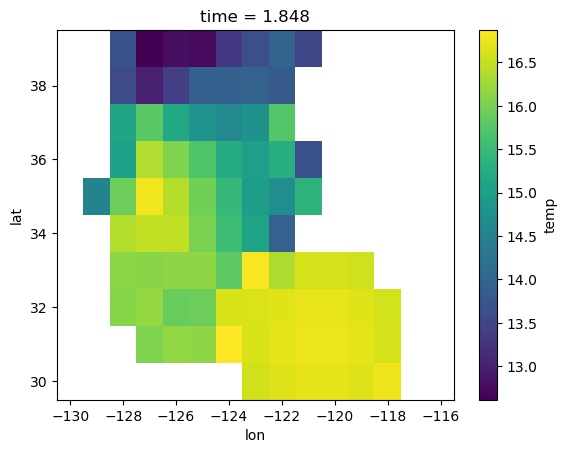

In [6]:


# --- STEP 2: VALIDATE & TUNE (Phase 2) ---
# We run the cross-validation to find the optimal physics (Length Scale & Noise).
# auto_tune=True lets the AI find the parameters.
validation_results = ag.generalized_cross_validation(
    df_argo_shallow, 
    feature_cols=['lat', 'lon', 'time_days'], # 3D Mode
    target_col='temp',
    method='KFold',      # Use KFold for robust tuning
    auto_tune=True,      # Let it find the best params
    tune_iterations=5
)

# Extract the winning parameters
best_L = validation_results['best_length_scale']
best_N = validation_results['best_noise']

print(f"\n🏆 WINNING PARAMETERS:")
print(f"   Anisotropic Length Scale(s)")
print(f"   Lat:          {best_L[0]} (sigmas)")
print(f"   Lon:          {best_L[1]} (sigmas)")
print(f"   Time:         {best_L[2]} (sigmas)")
print(f"   Noise:        {best_N:.3f}")

# --- STEP 3: DEFINE THE GRID (The Output Box) ---
# Create a 1x1 degree grid for the California Current
# Time: Monthly steps (every 30 days) covering the data range
min_t = df_argo_shallow['time_days'].min()
max_t = df_argo_shallow['time_days'].max()

grid_lat = np.arange(30.0, 40.0, 1.0) 
grid_lon = np.arange(-130.0, -115.0, 1.0)
grid_time = np.arange(min_t, max_t, 30)

# --- STEP 4: GENERATE THE MAP (Phase 3) ---
# We feed the 'best_L' and 'best_N' directly into the mapper.
ds_map = ag.produce_kriging_map(
    df=df_argo_shallow,
    grid_lat=grid_lat,
    grid_lon=grid_lon,
    grid_time=grid_time,
    target_col='temp',
    final_length_scale=best_L,  # <--- AUTOMATIC HANDOFF
    final_noise=best_N,         # <--- AUTOMATIC HANDOFF
    is_3d=True
)

# --- STEP 5: INSPECT & SAVE ---
print("\n💾 Saving to NetCDF...")
ds_map.to_netcdf(f"Map_temp.nc")

# Visualization: Plot the first time slice
ds_map['temp'].isel(time=0).plot(cmap='viridis')

In [7]:
ds_map

<xarray.Dataset> Size: 29kB
Dimensions:      (time: 12, lat: 10, lon: 15)
Coordinates:
  * time         (time) float64 96B 1.848 31.85 61.85 ... 271.8 301.8 331.8
  * lat          (lat) float64 80B 30.0 31.0 32.0 33.0 ... 36.0 37.0 38.0 39.0
  * lon          (lon) float64 120B -130.0 -129.0 -128.0 ... -117.0 -116.0
Data variables:
    temp         (time, lat, lon) float64 14kB nan nan nan nan ... nan nan nan
    temp_uncert  (time, lat, lon) float64 14kB nan nan nan nan ... nan nan nan
Attributes:
    description:          Kriged Map of temp
    kernel_length_scale:  [2.0333669  4.00000878 0.41506207]
    kernel_noise:         0.04394008323097568
    units:                degC

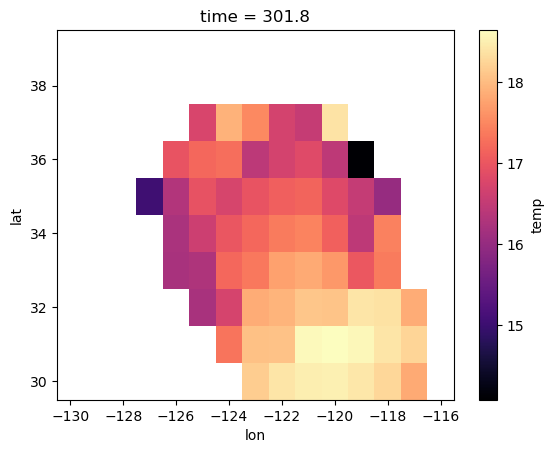

In [13]:
# Visualization: Plot the first time slice
ds_map['temp'].isel(time=10).plot(cmap='magma')

In [14]:
# Finally, let's try collating the pandas data frame and estimating ocean heat content. 
# YOU HAVE THE FUNCTION READY IN AHCD - test it out and then let's move on.

# NEXT. RUN LOOO with Moving Window (Baseline Check) 
# This validates if the model works mathematically, but properly accounts for how variable the physics is at different points in space
# Here, we have to consider the effects of the moving window as well. 
z_mv_LOOO = ag.validate_moving_window(df_argo_january, feature_cols=['lat', 'lon'], target_col='temp', 
                           method='KFold', radius_km = 300, tune_iterations=10)

# NEXT. RUNNING IN TIME AND ACTUAL KRIGING 
## We plan on estimating OHC at each argo point and then kriging on the 2D resultant fields. This way, each separate layer gets its own correlation lengths (which would be key
## seeing any difference between the separate profiles.)